# Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import struct
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

# Overview

Let's try to find how precise we could predict the traffic categories **without payload**.


In [2]:
combined_df = pd.read_csv('combined.csv')
print("Resulting dataset shape", combined_df.shape)
combined_df.head()

Resulting dataset shape (141530, 85)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,AUDIO-STREAMING


# Preprocessing

Renaming the two target columns Label and Label.1

In [3]:
combined_df.rename(columns = {'Label':'traffic', 'Label.1':'application'}, inplace = True)
combined_df.columns[-2:]

Index(['traffic', 'application'], dtype='object')

## Handing missing values

In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141530 entries, 0 to 141529
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow ID                     141530 non-null  object 
 1   Src IP                      141530 non-null  object 
 2   Src Port                    141530 non-null  int64  
 3   Dst IP                      141530 non-null  object 
 4   Dst Port                    141530 non-null  int64  
 5   Protocol                    141530 non-null  int64  
 6   Timestamp                   141530 non-null  object 
 7   Flow Duration               141530 non-null  int64  
 8   Total Fwd Packet            141530 non-null  int64  
 9   Total Bwd packets           141530 non-null  int64  
 10  Total Length of Fwd Packet  141530 non-null  int64  
 11  Total Length of Bwd Packet  141530 non-null  int64  
 12  Fwd Packet Length Max       141530 non-null  int64  
 13  Fwd Packet Len

In [5]:
def show_missing(df):
    """Return a Pandas dataframe describing the contents of a source dataframe including missing values."""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    infinity = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        if df[item].dtypes=='float64'or df[item].dtypes=='int64':
            infinity.append(np.isinf(df[item]).values.sum())
        else:
            infinity.append('not_supported')
        
    

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        'infinity':infinity
    
    })    
        
    return output

In [6]:
missing_table = show_missing(combined_df)

# data with infinity values
missing_table.loc[(missing_table['infinity']!=0) & (missing_table['infinity']!='not_supported')]

,variable,dtype,count,unique,missing,infinity
20,Flow Bytes/s,float64,141530,73856,47,2
21,Flow Packets/s,float64,141530,82670,0,49


In [7]:
# Drop data with NaN values
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_df.dropna(axis=0 ,inplace=True)

## Handling duplicates & final shape

In [8]:
combined_df = combined_df.drop_duplicates()
combined_df.shape

(117024, 85)

# Data visualization

In [9]:
combined_df['traffic'].unique()

array(['Non-Tor', 'NonVPN', 'Tor', 'VPN'], dtype=object)

In [10]:
combined_df['traffic'].value_counts()

traffic
Non-Tor    69065
NonVPN     23861
VPN        22919
Tor         1179
Name: count, dtype: int64

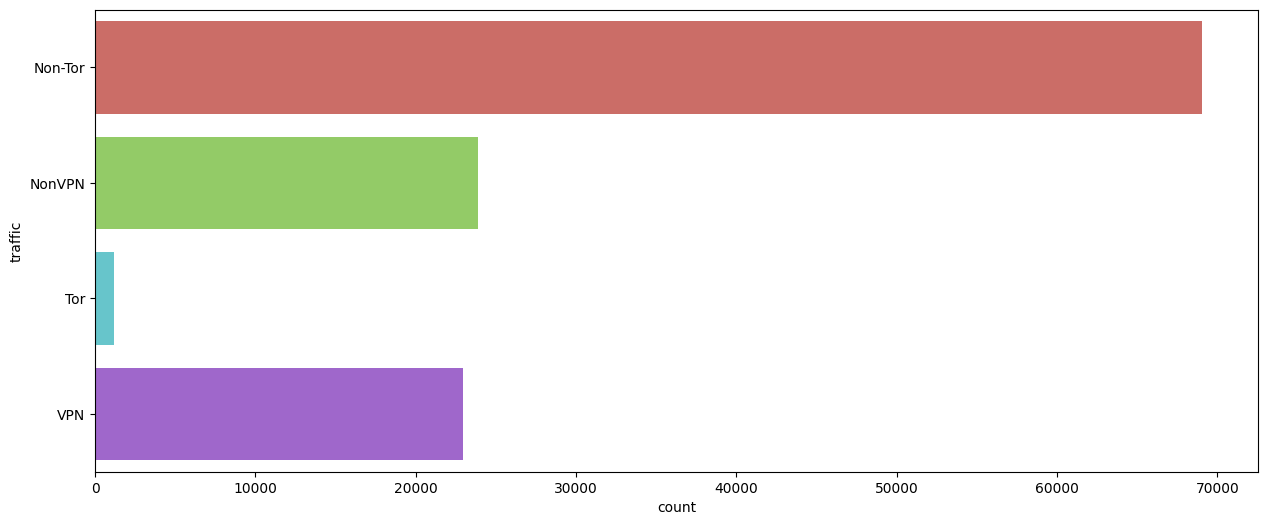

In [11]:
plt.figure(figsize=(15,6))
sns.countplot(combined_df['traffic'],
              palette='hls',)
plt.show()



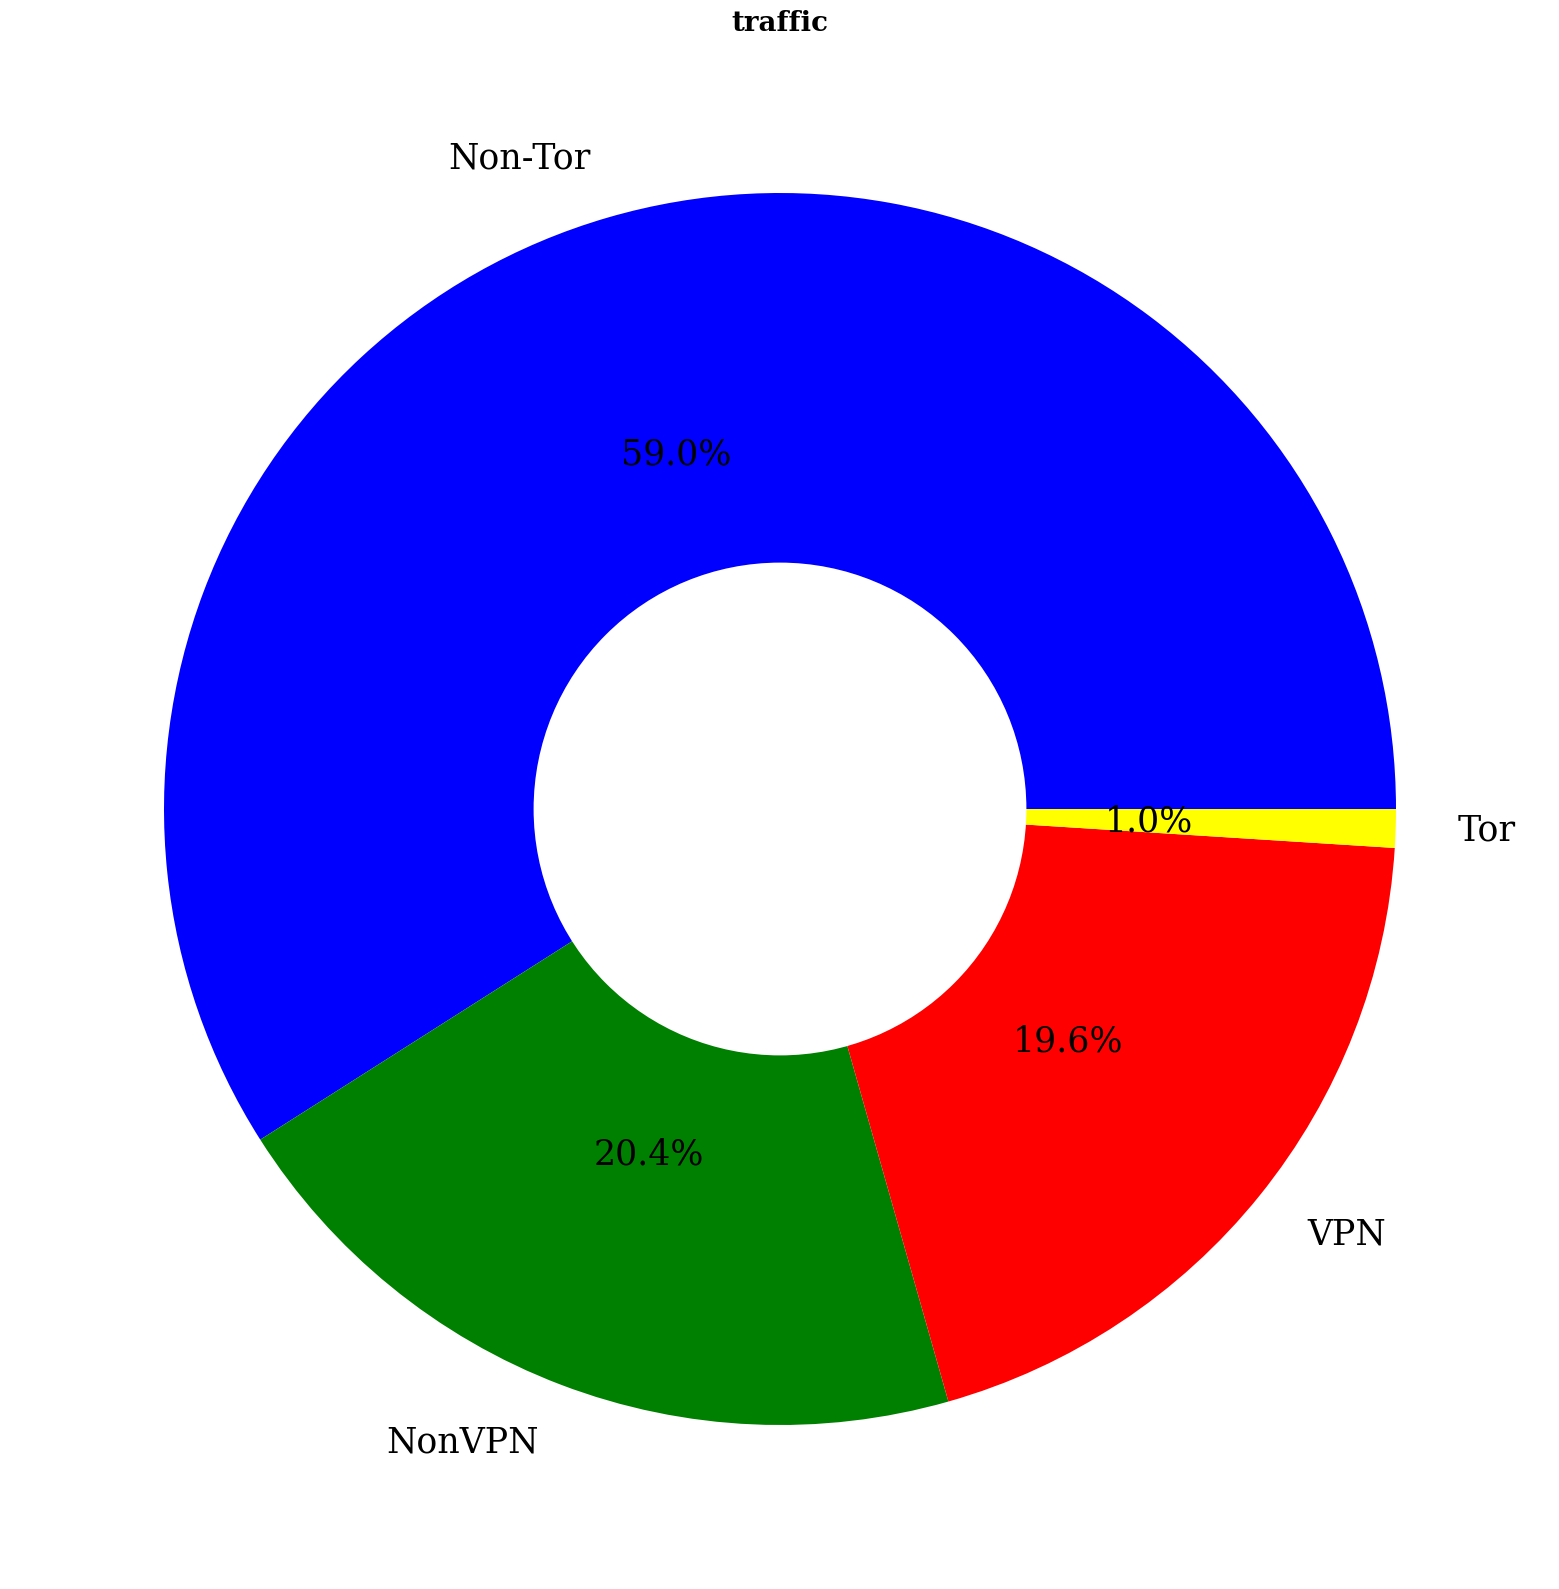

In [12]:
label_data=combined_df['traffic'].value_counts()
explode=(0.0,0.0,0.0,0.0)
plt.figure(figsize=(30,20))
patches, texts, pts= plt.pie(label_data,
                               labels=label_data.index,
                               colors=['blue','green','red','yellow'],
                               autopct='%1.1f%%',
                               textprops={'fontsize':25,
                                          'color':'black',
                                          'family':'serif'})
#plt.setp(pcts, color='black')
hfont={'fontname':'serif', 'weight':'bold'}
plt.title('traffic', size=20, **hfont)
centre_circle=plt.Circle((0,0),0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

In [13]:
combined_df['application'].unique()

array(['AUDIO-STREAMING', 'Browsing', 'Chat', 'Email', 'File-Transfer',
       'File-transfer', 'P2P', 'Video-Streaming', 'Audio-Streaming',
       'Video-streaming', 'VOIP'], dtype=object)

In [14]:
combined_df['application'].value_counts()

application
Browsing           32714
P2P                24260
Audio-Streaming    16477
Chat               11473
File-Transfer      11089
Video-Streaming     9467
Email               6143
VOIP                3566
AUDIO-STREAMING     1470
Video-streaming      281
File-transfer         84
Name: count, dtype: int64

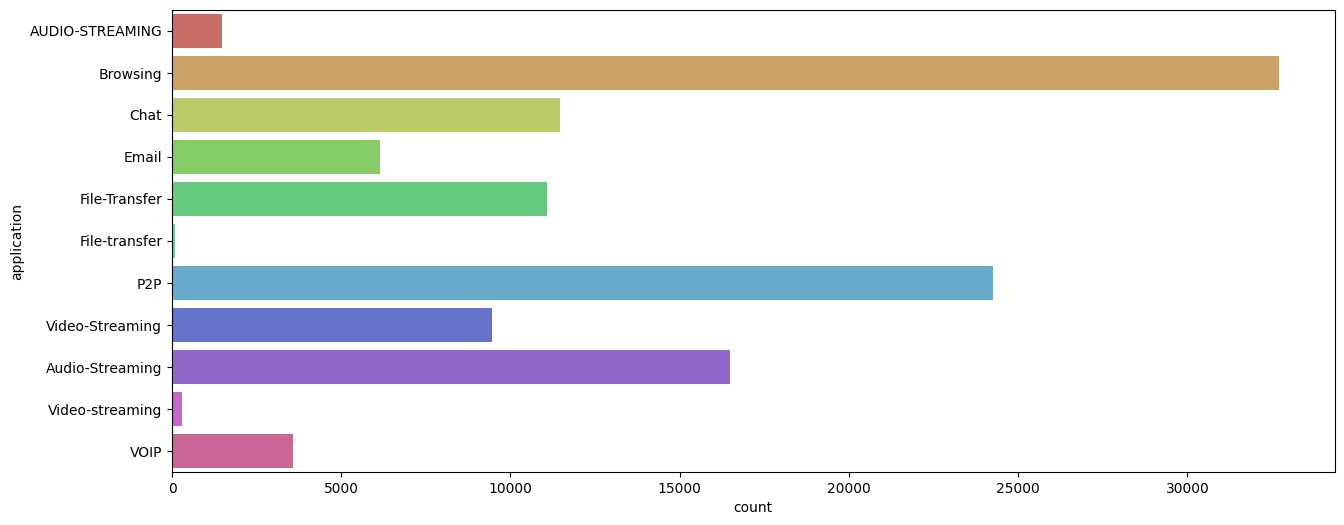

In [15]:
plt.figure(figsize=(15,6))
sns.countplot(combined_df['application'],
              palette='hls')
plt.show()

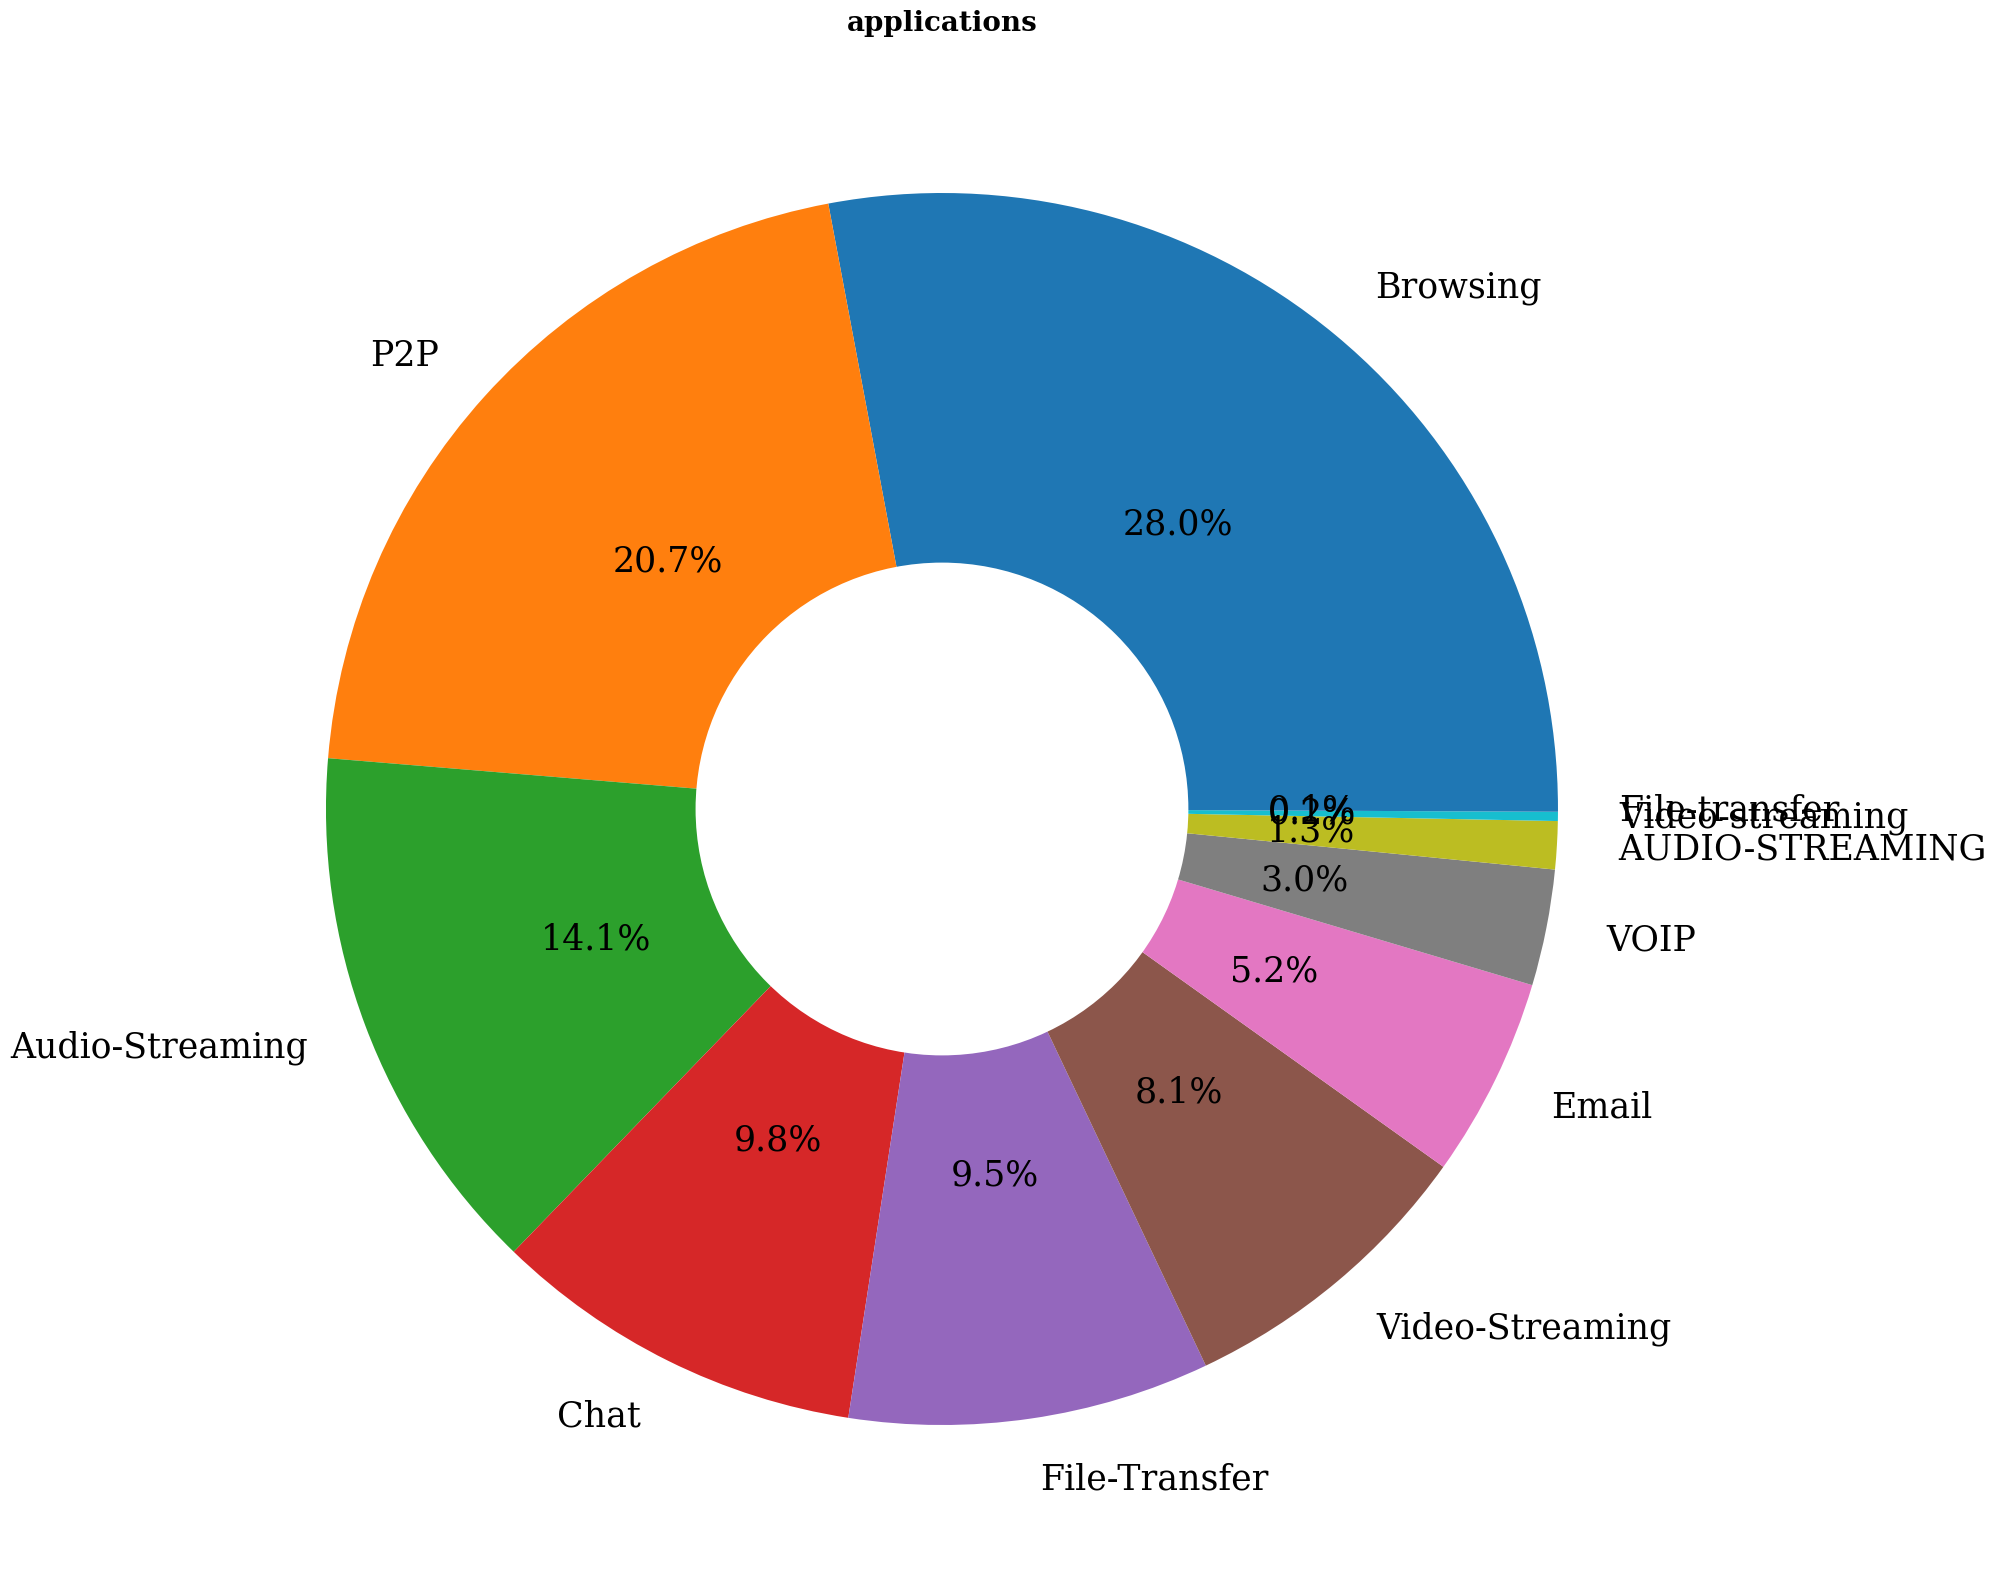

In [16]:
label_data=combined_df['application'].value_counts()
explode=(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)
plt.figure(figsize=(30,20))
patches, texts, pts= plt.pie(label_data,
                               labels=label_data.index,
                               autopct='%1.1f%%',
                               textprops={'fontsize':25,
                                          'color':'black',
                                          'family':'serif'})
#plt.setp(pcts, color='black')
hfont={'fontname':'serif', 'weight':'bold'}
plt.title('applications', size=20, **hfont)
centre_circle=plt.Circle((0,0),0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

Data still a bit messy even after processing during merge. Let's a bit prettify it

# Splitting the data

In [17]:
NOT_VALUABLE_COLS = ['Src IP', 'Flow ID', 'Dst IP', 'Timestamp']

input_data = combined_df.drop(['traffic','application'] + NOT_VALUABLE_COLS, axis=1)
traffic_label = combined_df['traffic']
application_label = combined_df['application']
# Split data for the traffic label
Xtrain_traffic, Xtest_traffic, ytrain_traffic, ytest_traffic = train_test_split(
    input_data,traffic_label , random_state=104,test_size=0.2, shuffle=True)

Xtrain_traffic, Xval_traffic, ytrain_traffic, yval_traffic = train_test_split(
  Xtrain_traffic,ytrain_traffic , random_state=104,test_size=0.25, shuffle=True)

# Split data for the application label
Xtrain_application, Xtest_application, ytrain_application, ytest_application = train_test_split(
  input_data,application_label , random_state=104,test_size=0.2, shuffle=True)

Xtrain_application, Xval_application, ytrain_application, yval_application = train_test_split(
  Xtrain_application,ytrain_application , random_state=104, test_size=0.25, shuffle=True)

# Encoding labels

In [18]:
from sklearn.preprocessing import LabelEncoder

# Encode labels for traffic and application
label_encoder_traffic = LabelEncoder()
ytrain_traffic_encoded = label_encoder_traffic.fit_transform(ytrain_traffic)
ytest_traffic_encoded = label_encoder_traffic.transform(ytest_traffic)
label_encoder_application = LabelEncoder()
ytrain_application_encoded = label_encoder_application.fit_transform(ytrain_application)
ytest_application_encoded = label_encoder_application.transform(ytest_application)

# Model training


## traffic

In [19]:
# Step 1: Remove constant features with low variance
constant_filter = VarianceThreshold(0.1)
Xtrain_traffic_filtered = constant_filter.fit_transform(Xtrain_traffic)
Xtest_traffic_filtered = constant_filter.transform(Xtest_traffic)

# Step 2: Perform feature selection
rf_selector_traffic = RandomForestClassifier(n_estimators=100, random_state=104)
sfm_traffic = SelectFromModel(rf_selector_traffic)
Xtrain_traffic_selected = sfm_traffic.fit_transform(Xtrain_traffic_filtered, ytrain_traffic_encoded)
Xtest_traffic_selected = sfm_traffic.transform(Xtest_traffic_filtered)

# Step 3: Train Random Forest model and tune a bit
param_grid = {
    'n_estimators': [50, 150, 300],
    'max_depth': [None, 10, 30],
}

rf_traffic = RandomForestClassifier(random_state=104, class_weight='balanced')

grid_search_traffic = GridSearchCV(rf_traffic, param_grid, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=104),
                                   scoring='balanced_accuracy', verbose=2)
grid_search_traffic.fit(Xtrain_traffic_selected, ytrain_traffic_encoded)

# Step 4: Output multiple classification metrics for multilabel classification
y_pred_traffic = grid_search_traffic.predict(Xtest_traffic_selected)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=   7.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   8.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   7.8s
[CV] END ....................max_depth=None, n_estimators=50; total time=   7.2s
[CV] END ...................max_depth=None, n_estimators=150; total time=  21.8s
[CV] END ...................max_depth=None, n_estimators=150; total time=  23.5s
[CV] END ...................max_depth=None, n_estimators=150; total time=  22.7s
[CV] END ...................max_depth=None, n_estimators=150; total time=  23.0s
[CV] END ...................max_depth=None, n_estimators=300; total time=  48.0s
[CV] END ...................max_depth=None, n_estimators=300; total time=  44.7s
[CV] END ...................max_depth=None, n_estimators=300; total time=  43.1s
[CV] END ...................max_depth=None, n_est

### Visualizations and metrics

Classification Report for Traffic Label:
              precision    recall  f1-score   support

     Non-Tor       1.00      1.00      1.00     13870
      NonVPN       0.95      0.96      0.96      4729
         Tor       0.95      0.89      0.92       258
         VPN       0.96      0.95      0.96      4548

    accuracy                           0.98     23405
   macro avg       0.97      0.95      0.96     23405
weighted avg       0.98      0.98      0.98     23405



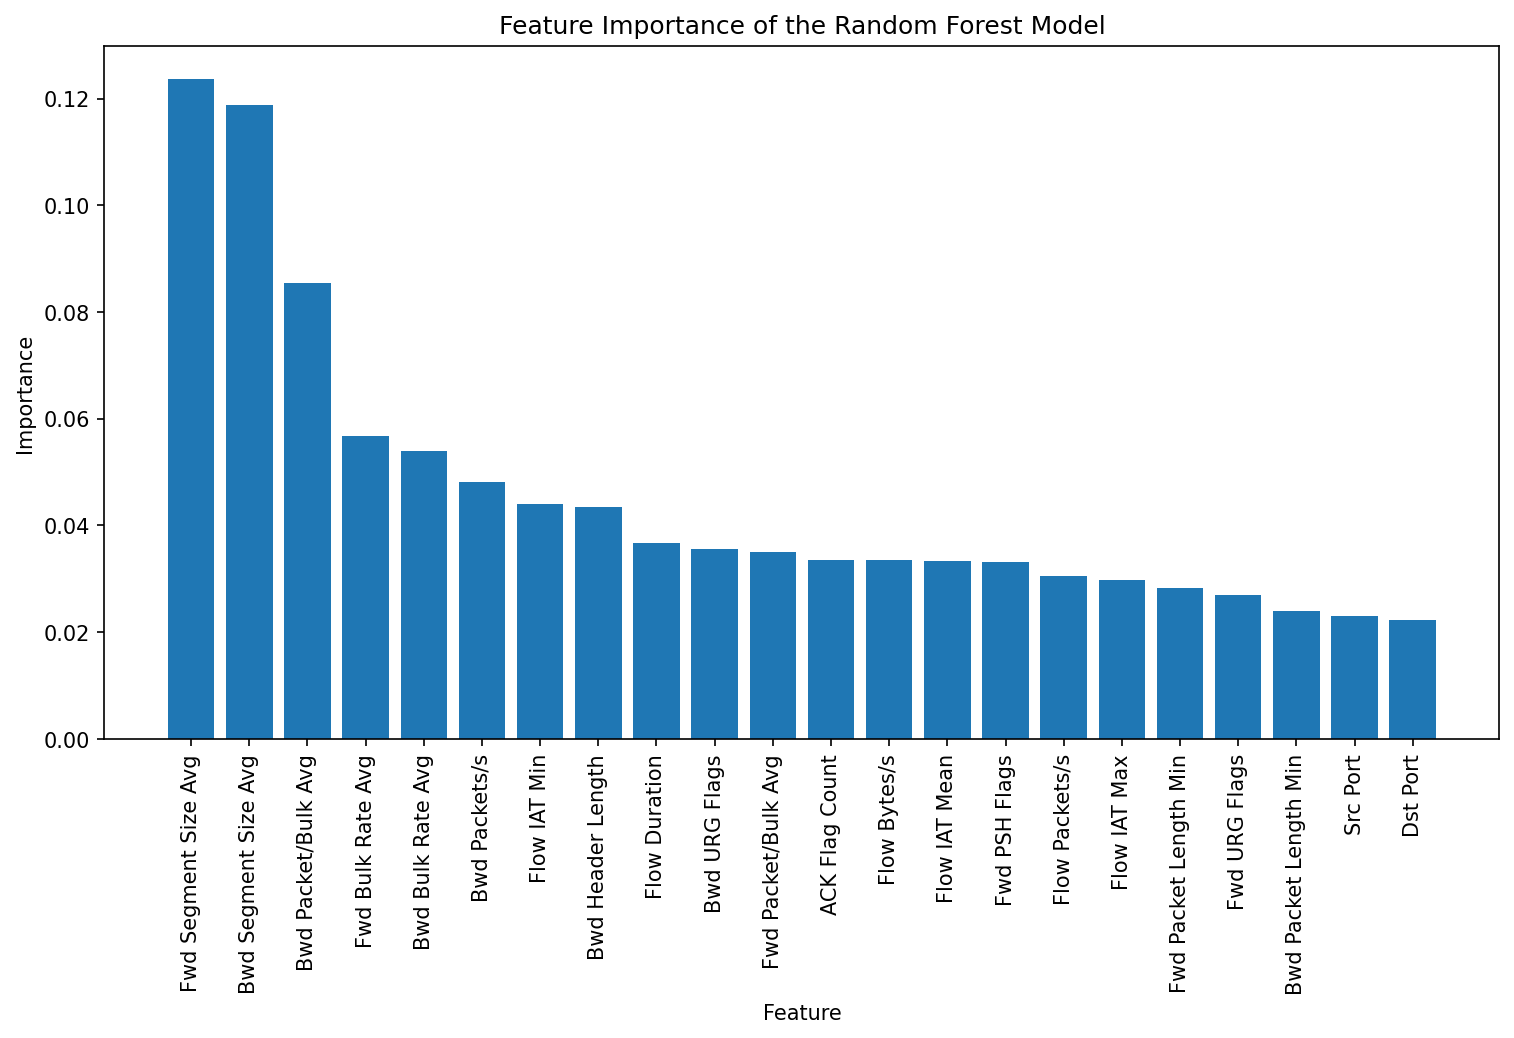

In [43]:

print("Classification Report for Traffic Label:")
print(
    classification_report(
        label_encoder_traffic.inverse_transform(ytest_traffic_encoded), 
        label_encoder_traffic.inverse_transform(y_pred_traffic), 
        target_names=label_encoder_traffic.classes_.tolist())
)

# Get feature importances from the trained RandomForestClassifier
feature_importances = grid_search_traffic.best_estimator_.feature_importances_
selected_feature_indices = sfm_traffic.get_support(indices=True)
selected_feature_names = Xtrain_traffic.columns[selected_feature_indices]
feature_importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6), dpi=150)
plt.bar(range(len(feature_importances)), feature_importance_df['Importance'], align='center')
plt.xticks(range(len(feature_importances)), feature_importance_df['Feature'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance of the Random Forest Model')
plt.show()


## Application

In [44]:
# Step 1: Remove constant features with low variance
constant_filter = VarianceThreshold(0.1)
Xtrain_application_filtered = constant_filter.fit_transform(Xtrain_application)
Xtest_application_filtered = constant_filter.transform(Xtest_application)

# Step 2: Perform feature selection
rf_selector_application = RandomForestClassifier(n_estimators=100, random_state=104)
sfm_application = SelectFromModel(rf_selector_application)
Xtrain_application_selected = sfm_application.fit_transform(Xtrain_application_filtered, ytrain_application_encoded)
Xtest_application_selected = sfm_application.transform(Xtest_application_filtered)

# Step 3: Train Random Forest model and tune a bit
param_grid = {
    'n_estimators': [50, 150, 300],
    'max_depth': [None, 10, 30],
}

rf_application = RandomForestClassifier(random_state=104, class_weight='balanced')

grid_search_application = GridSearchCV(rf_application, param_grid, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=104),
                                   scoring='balanced_accuracy', verbose=2)
grid_search_application.fit(Xtrain_application_selected, ytrain_application_encoded)

# Step 4: Output multiple classification metrics for multilabel classification
y_pred_application = grid_search_application.predict(Xtest_application_selected)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=  13.7s
[CV] END ....................max_depth=None, n_estimators=50; total time=  14.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=  13.6s
[CV] END ....................max_depth=None, n_estimators=50; total time=  15.0s
[CV] END ...................max_depth=None, n_estimators=150; total time=  43.1s
[CV] END ...................max_depth=None, n_estimators=150; total time=  38.3s
[CV] END ...................max_depth=None, n_estimators=150; total time=  39.6s
[CV] END ...................max_depth=None, n_estimators=150; total time=  39.7s
[CV] END ...................max_depth=None, n_estimators=300; total time= 1.3min
[CV] END ...................max_depth=None, n_estimators=300; total time= 1.3min
[CV] END ...................max_depth=None, n_estimators=300; total time= 1.3min
[CV] END ...................max_depth=None, n_est

Classification Report for application Label:
                 precision    recall  f1-score   support

AUDIO-STREAMING       0.40      0.87      0.55       288
Audio-Streaming       0.94      0.70      0.80      3309
       Browsing       0.90      0.90      0.90      6505
           Chat       0.87      0.45      0.59      2229
          Email       0.51      0.58      0.55      1241
  File-Transfer       0.79      0.78      0.78      2297
  File-transfer       0.78      0.41      0.54        17
            P2P       0.98      0.92      0.95      4878
           VOIP       0.40      0.84      0.54       689
Video-Streaming       0.55      0.75      0.63      1898
Video-streaming       0.10      0.72      0.18        54

       accuracy                           0.79     23405
      macro avg       0.66      0.72      0.64     23405
   weighted avg       0.84      0.79      0.80     23405



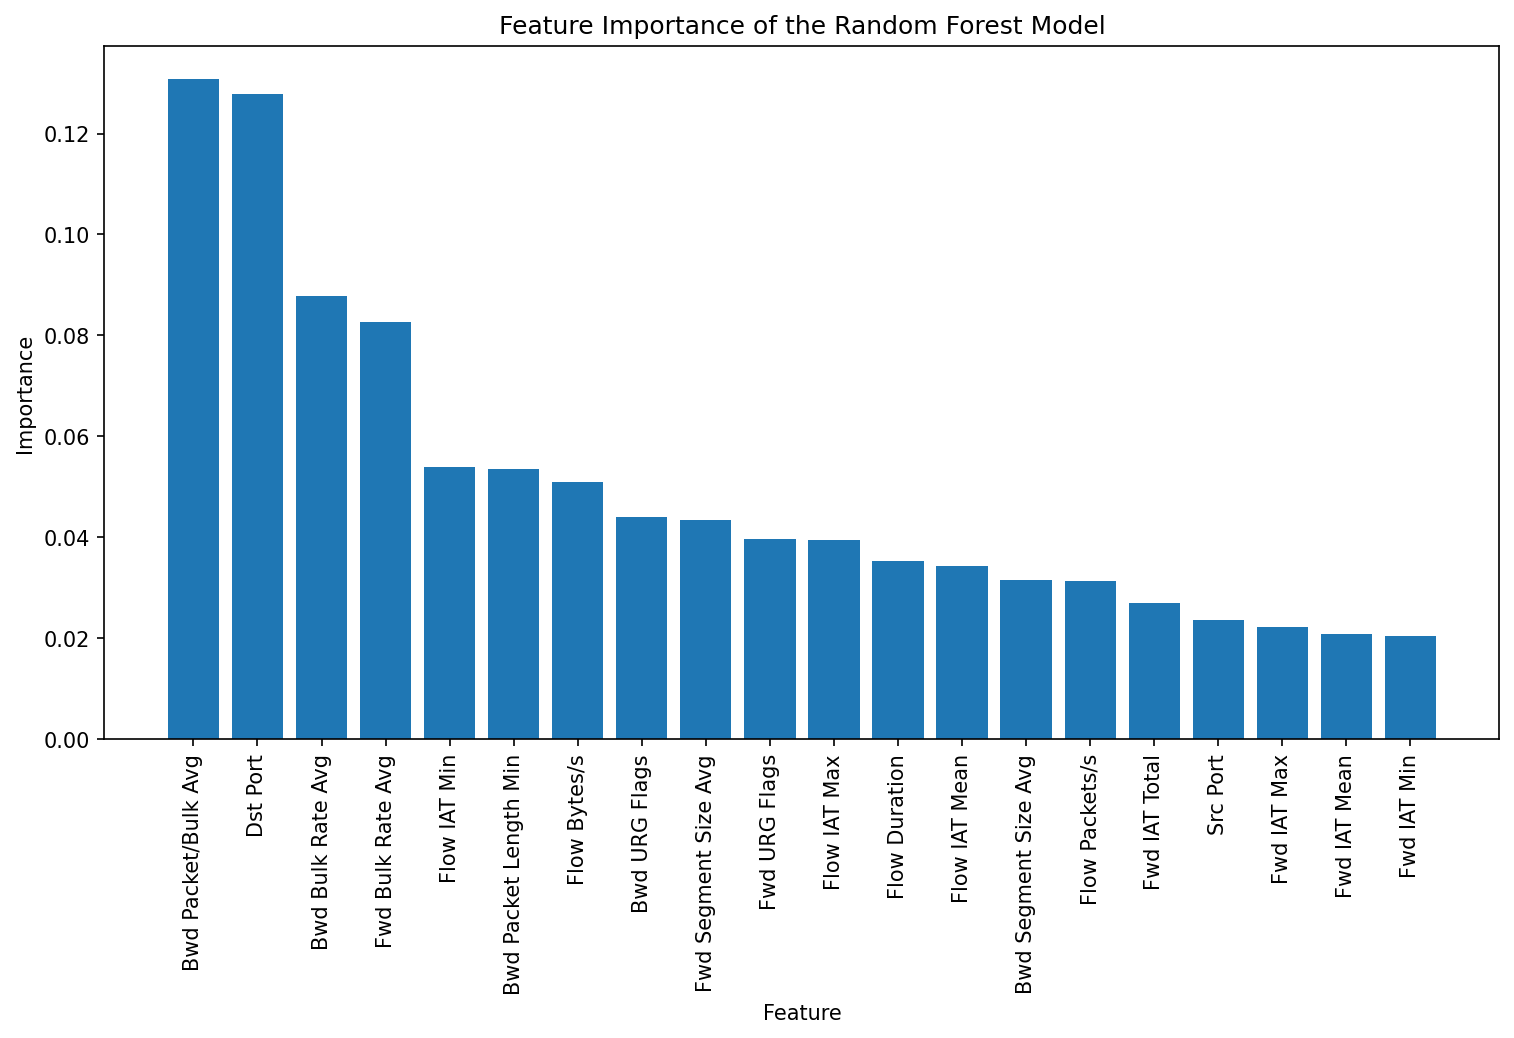

In [45]:

print("Classification Report for application Label:")
print(
    classification_report(
        label_encoder_application.inverse_transform(ytest_application_encoded), 
        label_encoder_application.inverse_transform(y_pred_application), 
        target_names=label_encoder_application.classes_.tolist())
)

# Get feature importances from the trained RandomForestClassifier
feature_importances = grid_search_application.best_estimator_.feature_importances_
selected_feature_indices = sfm_application.get_support(indices=True)
selected_feature_names = Xtrain_application.columns[selected_feature_indices]
feature_importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6), dpi=150)
plt.bar(range(len(feature_importances)), feature_importance_df['Importance'], align='center')
plt.xticks(range(len(feature_importances)), feature_importance_df['Feature'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance of the Random Forest Model')
plt.show()
